## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://stackoverflow.com/questions/33998740/error-in-reading-a-csv-file-in-pandascparsererror-error-tokenizing-data-c-err
df = pd.read_csv('../datasets/cfb_cbball', lineterminator='\n')

print(df.shape)
df.head()

(1421, 7)


,selftext,subreddit,title,post,post_length,post_word_count,stemmed_post
0,I have seen several times during all the re-al...,1,How do research budgets impact conferences?,How do research budgets impact conferences? I ...,570,89,how do research budget impact confer ? i have ...
1,[https://www.espn.com/college-football/story/\...,1,Penn State AD says the Big Ten has more than m...,Penn State AD says the Big Ten has more than m...,889,103,penn state ad say the big ten ha more than mon...
2,247 Profile: https://247sports.com/Player/Trav...,1,2022 5* DT Travis Shaw commits to North Carolina,2022 5* DT Travis Shaw commits to North Caroli...,186,13,2022 5 * dt travi shaw commit to north carolin...
3,We are one week away from the greatest sport i...,1,One Week Away,One Week Away We are one week away from the gr...,444,76,one week away we are one week away from the gr...
4,[https://twitter.com/naevail/status/1429186980...,1,2022 3* S Nathan Vail commits to Duke,2022 3* S Nathan Vail commits to Duke [ [,266,9,2022 3 * s nathan vail commit to duke [ [


In [3]:
cfb_stop_words = ['football', 'playoff', 'field', 'gameday', 'quarterback', 'heisman']
cfb_stop_words = text.ENGLISH_STOP_WORDS.union(cfb_stop_words)

cfb_cvec = CountVectorizer(stop_words = cfb_stop_words)
cfb_sub = df['post'][df['subreddit'] == 1]
cfb_cvec.fit(cfb_sub)
# Sophie's NLP walkthrough

CountVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [4]:
bball_stop_words = ['basketball', 'tournament', 'court', 'dribble', 'shoot', 'league']
bball_stop_words = text.ENGLISH_STOP_WORDS.union(bball_stop_words)

bball_cvec = CountVectorizer(stop_words = bball_stop_words)
bball_sub = df['post'][df['subreddit'] == 0]
bball_cvec.fit(bball_sub)
# Sophie's NLP walkthrough

CountVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [5]:
stop_words = cfb_stop_words.union(bball_stop_words)
# Sophie's NLP walkthrough

## Modeling

### Baseline Model

In [6]:
X = df['stemmed_post']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 34)

y.value_counts(normalize=True)

1    0.574243
0    0.425757
Name: subreddit, dtype: float64

57% of the time the model is correct in choosing the post came from the r/CFB subreddit

### Logistic Regression

In [7]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 34))
])

params = {
    'tfid__stop_words': ['english'],
    'tfid__strip_accents': ['ascii'],
    'tfid__max_features': [None, 400, 500],
    'tfid__max_df': [.1],
    'lr__n_jobs': [-1],
    'lr__solver': ['liblinear', 'lbfgs']
}

gs = GridSearchCV(pipe, param_grid = params)
gs.fit(X_train, y_train)
print('Cross val score:', gs.best_score_)
print(gs.best_params_)

Cross val score: 0.8225352112676056
{'lr__n_jobs': -1, 'lr__solver': 'liblinear', 'tfid__max_df': 0.1, 'tfid__max_features': None, 'tfid__stop_words': 'english', 'tfid__strip_accents': 'ascii'}


In [8]:
gs.score(X_test, y_test)

0.8033707865168539

In [9]:
pred = gs.predict(X_test)
(pred != y_test).mean()

0.19662921348314608

Accuracy: 0.8033707865168539
Sensitivity: 0.9455445544554455
Precision: 0.764
Recall: 0.9455445544554455
F1: 0.8451327433628318
Cross val score: 0.8225352112676056


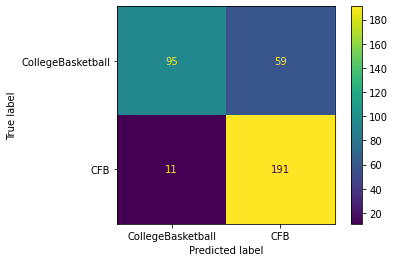

In [10]:
plot_confusion_matrix(gs, X_test, y_test, display_labels = ['CollegeBasketball', 'CFB']);

print('Accuracy:', gs.score(X_test, y_test))
print('Sensitivity:', metrics.recall_score(y_test, pred))
print('Precision:', metrics.precision_score(y_test, pred))
print('Recall:', metrics.recall_score(y_test, pred))
print('F1:', metrics.f1_score(y_test, pred))
print('Cross val score:', (gs.best_score_))

### Random Forest Classifier

In [11]:
pipe_2 = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 34))
])

params_2 = {
    'tfid__max_features': [None, 400, 500],
    'tfid__stop_words': ['english'],
    'tfid__strip_accents': ['ascii'],
    'tfid__max_df': [.1],
    'rf__max_depth': [None, 5, 6, 7],
    'rf__min_samples_leaf': [1, 2, 3, 4],
    'rf__n_estimators': [75, 100, 125],
    
}

gs_2 = GridSearchCV(pipe_2, param_grid = params_2, n_jobs = -1)
gs_2.fit(X_train, y_train)
print('Cross val score:', gs_2.best_score_)
# print(gs_2.best_params_)

Cross val score: 0.8403755868544602


In [12]:
gs_2.score(X_test, y_test)

0.8061797752808989

In [13]:
pred_2 = gs_2.predict(X_test)
(pred_2 != y_test).mean()

0.19382022471910113

Accuracy: 0.8061797752808989
Sensitivity: 0.9158415841584159
Precision: 0.7805907172995781
Recall: 0.9158415841584159
F1: 0.8428246013667428
Cross val score: 0.8403755868544602


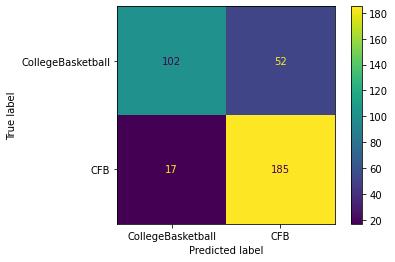

In [14]:
plot_confusion_matrix(gs_2, X_test, y_test, display_labels = ['CollegeBasketball', 'CFB']);

print('Accuracy:', gs_2.score(X_test, y_test))
print('Sensitivity:', metrics.recall_score(y_test, pred_2))
print('Precision:', metrics.precision_score(y_test, pred_2))
print('Recall:', metrics.recall_score(y_test, pred_2))
print('F1:', metrics.f1_score(y_test, pred_2))
print('Cross val score:', (gs_2.best_score_))